In [1]:
#imports
import sys
sys.path.append('../src')

import ipywidgets as widgets
import pandas as pd
import qiskit
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer, Aer, transpile, assemble
from qiskit.tools.visualization import plot_histogram
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

from Crypto.Hash import Poly1305
from Crypto.Cipher import AES
from binascii import unhexlify
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvas

from random import sample
import numpy as np
from numpy.random import randint
import panel as pn
import copy

import qkd
pn.extension()
pn.extension('terminal')
pn.extension('ipywidgets')

import time

from cascade.algorithm import ALGORITHMS
from cascade.key import Key
from cascade.mock_classical_channel import MockClassicalChannel
from cascade.reconciliation import Reconciliation



In [4]:
dashboard = None
mac = None

In [5]:
temp_backend = Aer.get_backend("qasm_simulator")
temp_air_sim = temp_backend

In [72]:
# Parameter selectors
#GUI element setup + creation
n_bits = pn.widgets.IntInput(name="Number of Qubits", value=10, step=1, start=10, end=1000000)
displacement = pn.widgets.FloatSlider(name="Distance (km)", value=0, step=1, start=0, end=20)
#% to db: db = 10 log(1+%)
#db to %:%=(10^db/10)*100
#print(1-1/pow(10,(displacement.value*0.4+2)/10))
#print(1-1/pow(10,(displacement.start*0.4+2)/10))
#print(1-1/pow(10,(displacement.end*0.4+2)/10))
decoherence = pn.widgets.FloatSlider(name="Decoherence rate", value=1-1/pow(10,(displacement.value*0.4+2)/10), step=0.01, start=1-1/pow(10,(displacement.start*0.4+2)/10), end=1-1/pow(10,(displacement.end*0.4+2)/10))
timesl = pn.widgets.FloatSlider(name="Time to establish first key (km)", value=488-(7.19*displacement.value)+(1.5*pow(displacement.value,2)), step=5, start=488-(7.19*displacement.start)+(1.5*pow(displacement.start,2)), end=488-(7.19*displacement.end)+(1.5*pow(displacement.end,2)))
receiver = pn.widgets.Select(name="Target", options=['Bob', 'Test'])
checkbitRatio = pn.widgets.FloatSlider(name="Checkbit ratio",value = 0.33,step= 0.01,start = 0, end = 1)
checkbitThresh = pn.widgets.FloatSlider(name="Checkbit threshold",value = 0.33,step= 0.01,start = 0, end = 1)
## Greesan --> more inputs Code for  qprot, eavesdropping, and solutions
qprotgroup = pn.widgets.RadioButtonGroup(
    name='cb_qprot', options=['BB84','Ekert'])
eavebox = pn.widgets.Checkbox(name='Eavesdropping')
eaveslide = pn.widgets.FloatSlider(name="Leftover Eavesdropping rate", value=0, step=0.01, start=0, end=1)
#eaveslide = pn.widgets.FloatSlider(name="Leftover Eavesdropping rate", value=0, step=0.01, start=0, end=1-decoherence.value)
#eaveslide.link(decoherence,'value')
isolgroup = pn.widgets.CheckButtonGroup(
    name='cb_i_soln', options=['SDN', 'Poly1305-AES'])
isol2 = pn.widgets.CheckButtonGroup(
    name='cb_i_soln', options=['Cascade'])
updatebutton = pn.widgets.Button(name="Update Inputs",button_type='primary')
AESgroup = pn.widgets.RadioButtonGroup(
    name='AES', options=['pre-shared', 'time-sync key gen'])
fig0 = Figure()
#x = []
#y = []
#x += [0,1,2]
#y += ['Start','After Sifting','After Checkbit Comparison']
#plt.plot(x,y, color='red', marker='o')
#plt.title('Bit Loss Over QKD Stages', fontsize=14)
#plt.xlabel('Stage', fontsize=14)
#plt.ylabel('# of Key Bits', fontsize=14)
#plt.grid(True)
FigureCanvas(fig0)
mpl_pane = pn.pane.Matplotlib(fig0, dpi=144)
bitpreval = n_bits.value
dispreval = displacement.value
decopreval = decoherence.value
eaveprebool = eavebox.value
eavepreval = eaveslide.value
timepreval = timesl.value

In [73]:

keys = []
bases = []
encoded_output = []

bob_results = []
# Generate key
def generate_key(event=None):
    """
    Function for generating a random key and bases of length n.
    
    :param n: length of bitstring to generate
    """
    n = n_bits.value
    bit_key = randint(2, size=n)
    bit_basis = randint(2, size=n)
    
    keys.append(bit_key)
    bases.append(bit_basis)
    
    if select_auth.value == 'Poly1305':
        secret = b'Thirtytwo very very secret bytes'
        
        global mac
        mac = Poly1305.new(key=secret, cipher=AES)
        mac.update(b'Hello')
        print("Nonce: ", mac.nonce.hex())
        print("MAC:   ", mac.hexdigest())

        time.sleep(0.25)
        terminal.write("Nonce: " + str(mac.nonce.hex()) + "\n")
        time.sleep(0.25)
        terminal.write("MAC:   " + str(mac.hexdigest()) + "\n")
        time.sleep(0.25)
    
    
    
    terminal.write("\nGenerating " + str(n) + "-qubit key and basis ")
    for i in range(3):
        time.sleep(0.25)
        terminal.write(".")
    time.sleep(0.25)
    terminal.write(" Finished")
    time.sleep(0.4)
    terminal.write("\nAlice's Key: " + str(bit_key) + "\nAlice's EncodingBasis: " + str(bit_basis))
    
generate_button = pn.widgets.Button(name="Generate key")
generate_button.on_click(generate_key)

qubit_select = pn.widgets.Select(name="Qubit", options=[])

measure_button = pn.widgets.Button(name="Measure")
### Write code for key with eavesdropper with measure
# Outputs
terminal = pn.widgets.Terminal("Welcome to the QKD Simulator.\n\n", height = 750, width = 700, options={"cursorBlink": True})
clear_terminal = pn.widgets.Button(name="Clear terminal")


send_button = pn.widgets.Button(name="Send")

measure_terminal = pn.widgets.Terminal(height=120, sizing_mode='stretch_width', options={"cursorBlink": True})

def send(event=None):
    #msg_receiver = receiver.value
    
    terminal.write("\nEncoding ")
    encode()
    for i in range(3):
        time.sleep(0.25)
        terminal.write(".")
    time.sleep(0.25)
    terminal.write(" Sent")
    time.sleep(0.4)
    
def encode(event=None):
    """
    Function for encoding a message.
    
    :param bit_key: Randomly generated bitstring key
    :param bit_bases: Bases for each bit in bit_key
    """
    bit_key = keys[-1]
    bit_bases = bases[-1]
    output = []
    
    # length of bit_key and bit_bases should be the same
    assert len(bit_key) == len(bit_bases), "Key and bases sequence should be equivalent."
    
    for i in range(len(bit_key)):
        qc = QuantumCircuit(1, 1)
        
        # Encode qubit in Z-basis (horizontal-vertical)
        if bit_bases[i] == 0:
            if bit_key[i] == 0:
                pass
            else:
                qc.x(0)
        
        # Encode qubit in X-basis (diagonal)
        else:
            if bit_key[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
                
        qc.barrier()
        output.append(qc)
        
    encoded_output.append(output)
    qubit_select.options += ["Qubit " + str(i) for i in range(len(output))]

send_button.on_click(send)
    
def delete_text(event=None):
    terminal.clear()

clear_terminal.on_click(delete_text)

In [74]:
def measure_qubits(event=None):
    measure_terminal.clear()
    measure_terminal.write("\nMeasuring ")
    for i in range(3):
        time.sleep(0.25)
        measure_terminal.write(".")
    time.sleep(0.25)
    measure_terminal.write(" Finished")
    time.sleep(0.4)
    
    noise = decoherence.value
    measure_terminal.write(noise)
    msg = encoded_output[-1]
    n = n_bits.value
    bases = randint(2, size=n)
    
    if noise > 0:
        
        #temp_backend = Aer.get_backend("aer_simulator")
        temp_results = []
        
        noise_idx = []
        for i_n in range(int(len(msg)*noise)):
            noise_idx.append(random.randint(0, len(msg)-1))
            
        for n_idx in noise_idx:
            # Z-basis
            if bases[n_idx] == 0: 
                msg[n_idx].measure(0, 0)

             # X-basis
            if bases[n_idx] == 1:
                msg[n_idx].h(0)
                msg[n_idx].measure(0, 0)
                
            #temp_aer_sim = Aer.get_backend("aer_simulator")
            temp_qobj = assemble(msg[n_idx], shots=1, memory=True)
            temp_sim_results = temp_aer_sim.run(temp_qobj).result()
            temp_measured_bit = int(temp_sim_results.get_memory()[0])
            temp_results.append(temp_measured_bit)
            
    secret = b'Thirtytwo very very secret bytes'
    mac = Poly1305.new(key=secret, cipher=AES)
    mac.update(b'Hello')
    print("Nonce: ", mac.nonce.hex())
    print("MAC:   ", mac.hexdigest())
    
    passed = False
    msg_ = b"I am Alice."
    
    nonce_hex = mac.nonce.hex()
    mac_tag_hex = mac.hexdigest()

    secret = b'Thirtytwo very very secret bytes'
    nonce = unhexlify(nonce_hex)
    mac = Poly1305.new(key=secret, nonce=nonce, cipher=AES, data=msg_)
    try:
        mac.hexverify(mac_tag_hex)
        print("\nThe message '%s' is authentic" % msg_)
        passed = True
    except ValueError:
        print("\nThe message or the key is wrong")
        passed = False
         
    backend = Aer.get_backend("aer_simulator")
    results = []
    
    for i in range(len(msg)):
        # Z-basis
        if bases[i] == 0: 
            msg[i].measure(0, 0)
            
         # X-basis
        if bases[i] == 1:
            msg[i].h(0)
            msg[i].measure(0, 0)
            
        aer_sim = Aer.get_backend("aer_simulator")
        qobj = assemble(msg[i], shots=1, memory=True)
        sim_results = aer_sim.run(qobj).result()
        measured_bit = int(sim_results.get_memory()[0])
        results.append(measured_bit)
        
    bob_results.append(results)
    
    
    if passed == True:
        alice_msg = str("\nThe message is authentic.")
        measure_terminal.write(alice_msg + "\n")
        measure_terminal.write("\nGenerated Key: "+ str(results))
    
    else:
        measure_terminal.write("\nThe message or the key is wrong. Terminating ")
        for i in range(3):
            time.sleep(0.25)
            measure_terminal.write(".")
        
        measure_terminal.write("\nSession ended.")
        


measure_button.on_click(measure_qubits)

select_auth = pn.widgets.Select(name="Authentication Protocol", options=["Poly1305", "AES", "ZKP"])

pre_shared = pn.widgets.TextInput(name="Pre-Shared Key", value='Thirty two very very secret bytes')

auth_input = pn.widgets.TextInput(name="Authentication Tag", value='Thirty two very very secret bytes')

#updash()

measurement = pn.Row(pn.WidgetBox(auth_input, measure_button, height=120), measure_terminal)

In [75]:
def generate_key2(n):
    """
    Function for generating a random key and bases of length n.
    
    :param n: length of bitstring to generate
    """
    bit_key = randint(2, size=n)
    bit_basis = randint(2, size=n)
    
    return bit_key, bit_basis

# Code for measuring
def encode2(bit_key, bit_bases):
    """
    Function for encoding a message.
    
    :param bit_key: Randomly generated bitstring key
    :param bit_bases: Bases for each bit in bit_key
    """
    output = []
    
    # length of bit_key and bit_bases should be the same
    assert len(bit_key) == len(bit_bases), "Key and bases sequence should be equivalent."
    
    for i in range(len(bit_key)):
        qc = QuantumCircuit(1, 1)
        
        # Encode qubit in Z-basis (horizontal-vertical)
        if bit_bases[i] == 0:
            if bit_key[i] == 0:
                pass
            else:
                qc.x(0)
        
        # Encode qubit in X-basis (diagonal)
        else:
            if bit_key[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
                
        qc.barrier()
        output.append(qc)
        
    return output

In [9]:
def run_reconciliation(algorithm, key_size, error_method, error_rate):
    correct_key = Key.create_random_key(key_size)
    noisy_key = correct_key.copy(error_rate, error_method)
    actual_bit_errors = correct_key.difference(noisy_key)
    actual_bit_error_rate = actual_bit_errors / key_size
    print(correct_key)
    print(noisy_key)
    print(actual_bit_errors)
    print(actual_bit_error_rate)
    mock_classical_channel = MockClassicalChannel(correct_key)
    reconciliation = Reconciliation(algorithm, mock_classical_channel, noisy_key, error_rate)
    reconciliated_key = reconciliation.reconcile()
    remaining_bit_errors = correct_key.difference(reconciliated_key)
    remaining_bit_error_rate = remaining_bit_errors / key_size
    print(reconciliated_key)
    print(remaining_bit_errors)
    print(remaining_bit_error_rate)
    return

def run_reconciliation_multiple_times(runs, number_of_qbits, qbit_error_rate):
    for _ in range(runs):
        run_reconciliation("original", number_of_qbits, "exact", qbit_error_rate)

run_reconciliation_multiple_times(2, 10, 0.1)
    
    
    

1111100000
1101100000
1
0.1
1111100000
0
0.0
1101000100
1101000000
1
0.1
1101000100
0
0.0


## Our BB84 Code Implementation

In [76]:
#input: Alice bit string, Alice basis string
#output: quantum circuit with Alice's encoded bits, 1) visual, 2) actual qc, 3)encoded bitstring of '01+-' states 
def encodeBits(abits,abasis):
    s = "["
    realqc = QuantumCircuit(len(abits),1)
    qc = QuantumCircuit(len(abits))
    for i in range(len(abits)):
        #qc.append(#QuantumCircuit(len(abits)))
        if abits[i] == 0:
            if abasis[i] == 0:
                s+='0'
            else:
                qc.h(i)
                realqc.h(i)
                s+='+'
        else:
            qc.x(i)
            realqc.x(i)
            if abasis[i] == 0:
                s+='1'
            else:
                qc.h(i)
                realqc.h(i)
                s+='-'
        if i < len(abits)-1:
            s+= " "
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,s+"]")

In [77]:
#input: noise as percentage, quantum circuit with Alice bits encoded(visual and actual), basis holds #qubits
#output: quantum circuit with Alice bits encoded(visual and actual), list of qubits affected by noise
def decomeasure(perc,qc,realqc,basis):
    measseq = []
    measgate = QuantumCircuit(1, name='NOISE')
    for i in range(len(basis)):
        #print("meas",i)
        if randint(0,100) < perc*100:
            #print(i,"is measured")
            qc.append(measuregate,[i])
            realqc.measure(i,0)
            measseq.append(i)
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,measseq)

In [78]:
#input: eavesdropping as percentage, quantum circuit with Alice bits encoded and noised(visual and actual), basis holds #qubits
#output: quantum circuit with Alice bits encoded(visual and actual),list of qubits successfully eavesdropped on, list of qubits affected by eave's failure to choose the correct basis
measuregate = QuantumCircuit(1, name='MEAS')
def eavesdrop(perc,qc,realqc,basis):
    eave = 0
    eavesucc = []
    eavefail = []
    eavesuccgate = QuantumCircuit(1, name='EAVECB') #CB --> correct basis
    eavefailgate = QuantumCircuit(1, name='EAVEWB') #WB --> wrong basis
    for i in range(len(basis)):
        if randint(0,100) < perc*100:
            #eavecnt+=1
            r = randint(0,1)
            if basis[i] == r:
                eavesucc.append(i)
                qc.append(eavesuccgate,[i])
            else:
                eavefail.append(i)
                qc.append(eavefailgate,[i])
            qc.append(measuregate,[i])
            if r == 1:
                qc.h(i)
            realqc.measure(i,0)
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,eavesucc,eavefail)

In [79]:
#input: quantum circuit with Alice bits encoded, noised, and eavesdropped(visual and actual), alice and bob basis strings
#output: quantum circuit with Alice bits encoded, noised, and eavesdropped
def bobmeasure(qc,realqc,bobbasis,alicebasis):
    matchseq = []
    for i in range(len(bobbasis)):
        if bobbasis[i] == 1:
            qc.h(i)
            realqc.h(i)
        if bobbasis[i] == alicebasis[i]:
            matchseq.append(i)
            #print("bit " + str(i) + " matches")
        qc.append(measuregate,[i])
    for i in range(len(bobbasis)):
        realqc.measure(i,0)
    #realqc.measure(list(range(len(alicebasis))),0)
    return (qc,realqc,matchseq)

In [80]:
#using Geeks for Geeks as reference for array intersection code: https://www.geeksforgeeks.org/union-and-intersection-of-two-sorted-arrays-2/
#input: 2 list
#output: intersection of two lists
def inter(arr1, arr2):
    i, j = 0, 0
    conjarr = []
    while i < len(arr1) and j < len(arr2):
        if arr1[i] < arr2[j]:
            i += 1
        elif arr1[i] > arr2[j]:
            j += 1
        else:
            conjarr.append(arr1[i])
            j += 1
            i += 1
    return conjarr

In [81]:
#input: 2 lists
#output: union of two lists
def un(arr1,arr2):
    conjarr = sorted(list(set(arr1) | set(arr2)))
    return conjarr

In [82]:
#input: 2 lists
#output: list of elements in arr1 not in arr2
def aleft(arr1, arr2):
    i, j = 0, 0
    conjarr = []
    while i < len(arr1) and j < len(arr2):
        if arr1[i] < arr2[j]:
            conjarr.append(arr1[i])
            i += 1
        elif arr1[i] > arr2[j]:
            j += 1
        else:
            j += 1
            i += 1
    while i < len(arr1):
        conjarr.append(arr1[i])
        i+=1
    return conjarr

In [83]:
#input: sequence of matching basis between Alice and Bob,number of bits
#output: sequence of nonmatching basis
def dropbits(matchseq,bitLength):
    dropseq = []
    for i in range(bitLength):
        if i not in matchseq:
            dropseq.append(i)
    return dropseq

In [84]:
#input: sequence of matching basis between Alice and Bob, number of bits
#output: calculated sequence list affected by successful eavesdropping, calculated sequence list affected by failed eavesdropping
def statsfromqcirc(n_bits,eavesucc,eavefail,matchseq):
    """
    dropseq = []
    for i in n_bits:
        if i not in matchseq:
            dropseq.append(i)
            
    #qbitdropseq = matchseq
    esptr = 0
    efptr = 0
    mptr = 0
    """
    eavesuccmatch = inter(eavesucc,matchseq)
    eavefailmatch = inter(eavefail,matchseq)
    
    
    """
    while mptr < len(matchseq) and esptr < len(eavesucc) and efptr < len(eavefail):
        if eavesucc[esptr] == qbitdropseq[mptr] or eavefail[efptr] == qbitdropseq[mptr]:
            if eavesucc[esptr] == qbitdropseq[mptr]:
                eavesuccmatch.append(matchseq[mptr])
            if eavefail[efptr] == qbitdropseq[mptr]:
                eavefailmatch.append(matchseq[mptr])
            del qbitdropseq[mptr]
            mptr -= 1
        elif eavesucc[esptr] < qbitdropseq[mptr] or eavefail[efptr] < qbitdropseq[mptr]:
            if(eavesucc[esptr] < qbitdropseq[mptr]):
                while esptr < len(eavesucc) and eavesucc[esptr] < qbitdropseq[mptr]:
                    esptr += 1
            if (eavefail[efptr] < qbitdropseq[mptr]):
                while efptr < len(eavefail) and eavefail[efptr] < qbitdropseq[mptr]:
                    efptr += 1
        while mptr < len(matchseq) and eavesucc[esptr] > qbitdropseq[mptr] and eavefail[efptr] > qbitdropseq[mptr]:
            mptr += 1
        mptr+=1
    """
    eavefailrateb4sift = len(eavefail) #possible to alert Bob
    eavesuccrateb4sift = len(eavesucc) #possible to eavesdrop without letting Bob know
    return (eavesuccrateb4sift, eavefailrateb4sift, eavesuccmatch, eavefailmatch)

In [85]:
#input: circuit before sifting, list of sequence of qubit wires to drop all gates from
#output: circuit after sifting
def remove_idle_qwires(circ,dropbits):
    #remove_arr = [1,2,3]
    i = 0
    while i < len(circ.data):
        #if len(circ.data[i][1]) > 1:
            #j = 0
            #while j < len(circ.data[i][1]):
            #    if circ.data[i][1][j].index in dropbits:
            #        del circ.data[]
        #print(circ.data[i][0])
        if circ.data[i][1][0].index in dropbits and circ.data[i][0].name != 'barrier': #ADD CODE HERE
            #print("here")
            del circ.data[i]
            i-=1
        i+=1
    #print(qc.data)
    #qc.draw()
    return circ
    
    """
    dag = circuit_to_dag(circ)
    layers = list(dag.multigraph_layers())
    #print(dag)
    idle_wires = list(dag.idle_wires())
    #print(idle_wires)
    dag = circuit_to_dag(qc)
    layers = list(dag.multigraph_layers())

    n_remove = 2

    # the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
    """
    """
    for layer in layers[- n_remove - 1:]:

        for node in layer:
            if node.type == 'op':
                dag.remove_op_node(node)
    """
 #   return (dag_to_circuit(dag),dag)

In [86]:
#input: circuit(visual and real) before sifting, list of sequence of qubit wires to drop all gates from
#output: circuits with wires corresponding to sifted out qubits removed
def remove_circuit_noise(qc,realqc,qbitdropseq):
    qcirc = remove_idle_qwires(qc,qbitdropseq)
    realqc = remove_idle_qwires(realqc,qbitdropseq)
    return (qcirc,realqc)

In [87]:
#generating random list of bits with size n
def genrand(n):
    bits = randint(2, size=n)
    return bits

In [88]:
def create_bob_bits(alicebits,noiseSeq,eaveFailSeq):
    temp = copy.deepcopy(alicebits)
    #print(noiseSeq)
    #print(eaveFailSeq)
    #print(un(noiseSeq,eaveFailSeq))
    for i in un(noiseSeq,eaveFailSeq):
        if temp[i] == 0:
            temp[i] = 1
        elif temp[i] == 1:
            temp[i] = 0
    return temp
    

In [89]:
#determining the checkbits to compare based on leftover bits after sifting and checkbit ratio

def compare_seq(ratio,matchbits):
    numCheck = max(1,round(len(matchbits)*ratio))
    checkbits = sample(matchbits,numCheck)
    
    return sorted(checkbits)

In [90]:
#Calculating checkbit sequence list affected by noise + eavesdropping,checkbit sequence list
#uneffected by noise + eavesdropping, and if security of key passes surpasses threshold --> determines
#key generation success or failure
#Note: only returning cbcheck, cbcheck2, ratio for debugging purposes
def checkBits(checkbits,eavefail,measseq,thresh):
    cbcheck = inter(checkbits,measseq)
    left = aleft(checkbits,measseq)
    #print(type(checkbits),type(eavefail))
    cbcheck2 = inter(checkbits,eavefail)
    cbcheck3 = un(cbcheck,cbcheck2)
    left = aleft(left,eavefail)
    succ = True
    ratio = len(cbcheck)/len(checkbits)
    if ratio>thresh:
        succ = False
    return(cbcheck,cbcheck2,cbcheck3,left,succ,ratio)

In [91]:
#list sequence to bitstring
def bitSeqToBits(arr,bits):
    s = ""
    for i in arr:
        s+=str(bits[i])
    return s

In [92]:
#return alice bits without checkbits
def removeCheckBits(bits,matchbits,checkbits):
    return bitSeqToBits(aleft(matchbits,checkbits),bits)

In [93]:
#graphing bits left after each stage
def graph(bb,start,afterSift,afterCheck,AES,cascade,event=None):
    fig = Figure()
    ax = fig.add_subplot(111)
    FigureCanvas(fig)
    x = []
    y = []
    if bb:
        x += ['Start','After Sifting','After Cb Compare']
        y += [start,afterSift,afterCheck]
    FigureCanvas(fig)
    ax.plot(x,y,color='red', marker='o')
    ax.set_title("Bit Loss by QKD Stage")
    #range(max val)
    bitrange = None
    if start <= 20:
        bitrange = range(0,start+1,2)
    elif start <= 200:
        bitrange = range(0,start+1,25)
    elif start <= 2000:
        bitrange = range(0,start+1,250)
    elif start <= 20000:
        bitrange = range(0,start+1,2500)
    elif start <= 200000:
        bitrange = range(0,start+1,25000)
    #print(list(bitrange))
    ax.set_yticks(list(bitrange))
    ax.set_xlabel('Stage')
    ax.set_ylabel('# of Key Bits')
    for i,j in zip(x,y):
        ax.annotate(str(j),xy=(i,j))
    fig.set_figheight(2)
    fig.set_figwidth(5)
    
    #pane = pn.pane.Matplotlib(fig, dpi=144)
    return fig

In [94]:
def bitstring_to_list(s):
    ls = []
    for i in s:
        ls.append(ord(i)-ord('0'))
    return ls

In [95]:
def phase_text(phase):
    return "\n________________________________________________________________________\n" + phase.upper() + " PHASE\n"
    
    
    

In [96]:
def AES_text(terminal,step,value,AESval):
    dic = dict()
    dic[1] = "basis"
    dic[2] = "sequence"
    dic[3] = "bit"
    if AESval != 0:
        if step == 1 or step == 3:
            terminal.write("\nAlice/Bob encrypts each " + dic[step] + " value separately to create a tag for each\n"
             + "value:" + str(value[0]) + str(value[1]))
            terminal.write("\nAlice and Bob publicly sends lists of nonces to each other")
        if step == 2:
            terminal.write("\nAlice encrypts each sequence value separately to create a tag for each \n"
             + "value:" + str(value))
            terminal.write("\nAlice publicly sends Bob a set of nonces")
        if AESval == 1:
            if step == 1 or step == 3:
                terminal.write("\nAlice/Bob uses the preshared key" + " and nonces" + " to start AES encryption on \n"
                    + "each value")
                terminal.write("\nThe tags sent are:")
                terminal.write("\nBob/Alice recieves tags and uses the preshared key to decrypt tags and\n"
                    + "authenticate that Alice/Bob has sent each value")
                terminal.write("\nBoth parties send acknowledgement of announcement\n")
            else:
                terminal.write("\nAlice uses the preshared key" + " and nonces" + " to start AES encryption bit by\nbit")
                terminal.write("\nThe tags sent are:")
                terminal.write("\nBob recieves the tags and uses the preshared key to decrypt tags and\n"
                    + "authenticate that Alice has sent each value")
                terminal.write("\nBob send acknowledgement of announcement\n")
        else:
            if step == 1:
                terminal.write("\nAlice/Bob share \"\"linked\"\" hardware that ensures that they create the same\n"
                    + "time-synced seed secret (implementation detailed in paper)\nthe secret created is:") 
            if step == 1 or step == 3:
                terminal.write("\nAlice/Bob uses the generated secret" + " and nonces" + " to start AES encryption on \n"
                    + "each value")
                terminal.write("\nThe tags sent are:")
                terminal.write("\nBob/Alice recieves the tags and uses the preshared key to decrypt tags and\n"
                    + "authenticate that Alice/Bob has sent each value")
                terminal.write("\nBoth parties send acknowledgement of announcement\n")
            else:
                terminal.write("\nAlice uses the generated secret" + " and nonces" + " to start AES encryption bit by\nbit")
                terminal.write("\nThe tags sent are:")
                terminal.write("\nBob recieves the tags and uses the preshared key to decrypt tags and\n"
                    + "authenticate that Alice has sent each value")
                terminal.write("\nBob send acknowledgement of announcement\n")
    else:
        if step == 1 or step == 3:
            terminal.write("\nAlice announces her " + dic[step] + " string over classical channel:\n" + str(value[0]))
            terminal.write("\nBob announces acknowledgement of Alice's announcement")
            terminal.write("\nBob announces his " + dic[step] + " string over classical channel:\n"+ str(value[1]))
            terminal.write("\nAlice announces acknowledgement of Bob's announcement\n")
        if step == 2:
            terminal.write("\nAlice announces that qubits " + str(value) + " will be used as checkbits.")
            terminal.write("\nBob sends acknowledgement of annoucement\n")

In [97]:
# Terminal-writing code for BB84
qc = None
bb84flag = False
Ekertflag = False
alicebits = []
bobbits = []
msg1 = msg2 = msg3 = None
def on_BB84(eaves,eaveprebool,eavesperc,eavepreval,decoperc,decopreval,bitval,bitpreval,AES,event=None):
    global bb84flag
    global Ekertflag
    global qc
    global terminal
    global alicebits
    global bobbits
    global msg1 
    global msg2 
    global msg3
    if True:
    #if not bb84flag or eavesperc!=eavepreval or decoperc!=decopreval or bitval != bitpreval:
        terminal.clear()
        terminal.write("\nBB84")
        #Alice encoding phase
        terminal.write(phase_text("alice encoding"))
        (alicebits,alicebasis) = generate_key2(n_bits.value)
        terminal.write("\nAlice Bits:               " + str(alicebits) + "\n")
        terminal.write("Alice Encoding Basis:     " + str(alicebasis) + "\n")
        (visqc,qc,s) = encodeBits(alicebits,alicebasis)
        terminal.write("Alice Bits After Encoding:" + s)
        #Noise creation phase
        terminal.write(phase_text("noise"))
        if decoperc>0:
            visqc,qc,decohereseq = decomeasure(decoperc,visqc,qc,alicebasis)
        terminal.write("\n" + str(len(decohereseq)) + " bits lost due to noise")
        terminal.write("\nbits lost are: " + str(decohereseq))
        #Eavedropping creation phase
        terminal.write(phase_text("eavesdropping"))
        eavesucc = []
        #siftedqubits = []
        if eaves and eavesperc>0:
            (visqc,qc,eavesucc,eavefail) = eavesdrop(eavesperc,visqc,qc,alicebasis)
            terminal.write("\nEavesdropping attempted on bits: "+ str(un(eavesucc,eavefail)))
        #Bob decoding phase
        terminal.write(phase_text("bob decoding"))
        bobbasis = genrand(n_bits.value)
        terminal.write("\nBob Decoding Basis:       " + str(bobbasis) + "\n")
        (visqc,qc,matchseq) = bobmeasure(visqc,qc,bobbasis,alicebasis)
        siftedqubits = dropbits(matchseq,n_bits.value)
        #terminal.write("\nAlice and Bob matching basis sequence:" + str(matchseq))
        #terminal.write("\nAlice and Bob mismatching basis sequence:" + str(siftedqubits))
        terminal.write(visqc.draw(output="text"))
        terminal.write("\n")
        eavefail = []
        eavefailrate = []
        eavefailaftersift = []
        #qbitdropseq, eavefailrate, eavefailrateaftersift,eavesuccrateaftersift
        if eaves and eavesperc>0:
            #print("hi2")
            (eavesuccrate, eavefailrate, eavesuccaftersift, eavefailaftersift) = statsfromqcirc(len(alicebits),eavesucc,eavefail,matchseq)
            #print(siftedqubits)
            #terminal.write("eavesuccseq after sift:" + str(eavesuccaftersift) + "\neavesfailseq after sift:" +  str(eavefailaftersift))
            terminal.write("\nAt this stage:\neavesdropper alert rate is " + str(eavefailrate) + "/" + str(len(alicebits)) + 
            "\neavesdropper success rate is " + str(eavesuccrate) + "/" + str(len(alicebits)))
        (visqc,qc) = remove_circuit_noise(visqc,qc,siftedqubits)
        #Communication of Basis Phase: 1ST CLASSICAL COMMUNICATION
        terminal.write(phase_text("Announcement of basis over Classical Channel"))
        AES_text(terminal,1,(alicebasis,bobbasis),AES)
        msg1 = (alicebasis,bobbasis)
        #Sifting Phase
        terminal.write(phase_text("Sifting"))
        terminal.write("\nAlice and Bob drop bits associated with nonmatching indexes of basis\nstrings")
        terminal.write("\nBits lost due to Bob's wrong basis selection: " + str(aleft(list(range(bitval)),matchseq)) + "\n")
        if eaves and eavesperc>0:
            terminal.write("\nafter sifting:\neavesdropper alert rate is " + str(len(eavefailaftersift)) + "/" + str(len(matchseq)) +
                            "\neavesdropper success rate is " + str(len(eavesuccaftersift)) + "/" + str(len(matchseq)))
        terminal.write("\nupdated circuit after sifting process\n")
        terminal.write(visqc.draw(output="text"))
        #terminal.write("\ncb1"+str(checkbit1))
        #terminal.write("\ncb2"+str(checkbit2))
        #terminal.write("\ncb3"+str(checkbit3))
        #terminal.write("\ncheckseq:" + str(checkseq))
        #terminal.write("\nmeasseq:" + str(decohereseq))
        #terminal.write("\neavefailseq:" + str(eavefailrate))
        #terminal.write("\ncheckeaveinter" + str(checkeaveinter))
        #Code to determine bob bitstring (possibly different from Alice's due to noise and eavesdropping)
        #sifteddecoseq = inter(matchseq,decohereseq)
        #print(sifteddecoseq)
        #print(eavefailaftersift)
        #print("dec" + str(decohereseq))
        #print("siftedqubits" + str(siftedqubits))
        bobbits = create_bob_bits(alicebits,decohereseq,eavefailaftersift)
        #terminal.write("\nAlice bits:" + str(alicebits))
        #terminal.write("\nBob bits:  " + str(bobbits))
        #Checkbit sequence announcement --> 2ND CLASSICAL COMMUNICATION
        #sequence sent from alice to bob
        checkseq = []
        terminal.write(phase_text("Checkbit Sequence Announcement over Classical Channel"))
        checkseq = compare_seq(checkbitRatio.value,matchseq)
        terminal.write("Alice decides to compare bits:" + str(checkseq))
        AES_text(terminal,2,checkseq,AES)
        msg2 = checkseq
        #Checkbit comparison announcement --> 3RD AND FINAL CLASSICAL COMMUNICATION
        terminal.write(phase_text("Checkbit Comparison through Announcement over Classical Channel"))
        terminal.write("\nAlice and Bob compare bits:                  " + str(checkseq))
        bitSeqToBits(checkseq,alicebits)
        alicebitcomp = bitstring_to_list(bitSeqToBits(checkseq,alicebits))
        bobbitcomp = bitstring_to_list(bitSeqToBits(checkseq,bobbits))
        AES_text(terminal,3,(alicebitcomp,bobbitcomp),AES)
        msg3 = (alicebitcomp,bobbitcomp)
        terminal.write("\nAlice's bits at indexes of checkbit sequence:" + str(alicebitcomp))
        terminal.write("\nBob's bits at indexes of checkbit sequence:  " + str(bobbitcomp))
        (checkbit1,checkbit2,checkbit3,bitsLeft,succ,ratio) = checkBits(checkseq,eavefail,decohereseq,checkbitThresh.value)
        terminal.write("\nnoise + eavesdropping failure rate: " + str(ratio))
        #key generation phase
        terminal.write(phase_text("Key Generation"))
        if not succ:
            terminal.write("\nAs noise + eavedropping failure rate after sifting: " + str(ratio) + "\nis greater than threshold rate in the checkbits compared: " + str(checkbitThresh.value) + "\nQKD has failed, please try again with larger key size\n")
            mpl_pane.object = graph(True,n_bits.value,len(matchseq),0,False,False)
        elif len(checkseq) >= len(matchseq):
            terminal.write("\nAs the checkbit ratio to circuit extrapolation steps doesn't provide enough leftover keybits, QKD key generation has failed\nPlease try again with larger key size\n")
            mpl_pane.object = graph(True,n_bits.value,len(matchseq),0,False,False)
        else:
            terminal.write("\nAs noise + eavedropping failure rate after sifting: " + str(ratio) + "\nis less than threshold rate in the checkbits compared: " + str(checkbitThresh.value) + "\nQKD has succeeded\n")
            aliceKeyAfterBB84 = removeCheckBits(alicebits,matchseq,checkseq)
            terminal.write("\nAlice's key is the leftover bits from her sifted bits: " + aliceKeyAfterBB84)
            bobKeyAfterBB84 = removeCheckBits(bobbits,matchseq,checkseq)
            terminal.write("\nBob's key is the leftover bits from his sifted bits:   " + bobKeyAfterBB84)
            if aliceKeyAfterBB84 == bobKeyAfterBB84:
                terminal.write("\nAs both keys match, there is no need to perform Cascade\n")
            else:
                terminal.write("\nAs both keys don't match, it would be useful to applying Cascade\nin order to remove key noise\n")
            mpl_pane.object = graph(True,n_bits.value,len(matchseq),len(aliceKeyAfterBB84),False,False)
        #terminal.write(dag)
    bb84flag = True
    Ekertflag = False
    #inputs: coherence
    #inputs: #bits
    #outputs:

In [98]:
#terminal-writing code for Ekert
def on_Ekert(event=None):
    global bb84flag
    global Ekertflag
    if not Ekertflag:
        terminal.clear()
        terminal.write("Ekert91\n")
        print("")
    bb84flag = False
    Ekertflag = True

In [99]:
#Not used
def on_eavesdrop(event=None):
    a = True
    #ouputs ->reveal eavesdropping ratio --> terminal displays eavesdropping content

In [100]:
##terminal-writing code for SDN
def on_SDN(event=None):
    a = True

In [101]:
#secret key generators --> separate function calls "emulating" 2 separate machines
def generate_secret_key_alice(n=16, delay = 10):
    
    delay_threshold = delay * 60 # delay is in minutes
    t = time.time()
    init_seed = int(np.ceil(t / delay_threshold))
    
    np.random.seed(np.abs(hash(str(init_seed)) // (2**32 - 1)))
    
    secret_key = np.random.bytes(n)
    
    return secret_key

def generate_secret_key_bob(n=16, delay = 10):
    
    delay_threshold = delay * 60 # delay is in minutes
    t = time.time()
    init_seed = int((t+delay_threshold) / delay_threshold)
    
    np.random.seed(np.abs(hash(str(init_seed)) // (2**32 - 1)))
    
    secret_key = np.random.bytes(n)
    
    return secret_key

In [102]:
alice_pre_shared = pn.widgets.TextInput(disabled=True, placeholder="16-byte Pre-shared Secret")
update_button = pn.widgets.Button(name="Generate Pre-shared")

alice_key = ""
def update_pre_shared(event = None):
    global alice_key
    alice_key = generate_secret_key_alice(n=16, delay = 10)
    alice_pre_shared.value = str(alice_key)
    
update_button.on_click(update_pre_shared)

alice_message = pn.widgets.TextInput(value="This is Alice.")
send_button = pn.widgets.Button(name="Send Message")

bob_pre_shared = pn.widgets.TextInput(disabled=True, placeholder="16-byte Pre-shared Secret")
generate_button = pn.widgets.Button(name="Generate Pre-shared")

bob_key = ""
def update_pre_shared_bob(event = None):
    global bob_key
    bob_key = generate_secret_key_bob(n=16, delay = 10)
    bob_pre_shared.value = str(bob_key)
    

generate_button.on_click(update_pre_shared_bob)

receive_input = pn.widgets.TextInput(disabled=True, value="Inbox")

verify_button = pn.widgets.Button(name="Verify")

verify_result = pn.widgets.TextInput(disabled=True, height = 90)

cipher = ""
data = ""
nonce = ""
ciphertext = ""
tag = ""
def send_message(event = None):
    key = alice_key
    global cipher
    cipher = AES.new(key, AES.MODE_EAX)
    global data
    data = bytes(alice_message.value, 'utf-8')
    global nonce
    nonce = cipher.nonce
    global ciphertext
    global tag
    ciphertext, tag = cipher.encrypt_and_digest(data)
    receive_input.value = "New message."
    
    
send_button.on_click(send_message)


def verify_msg(event = None):
    key = bob_key
    cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
    plaintext = cipher.decrypt(ciphertext)

    try:
        cipher.verify(tag)
        verify_result.value = "The message is authentic: " + str(plaintext)
    
    except ValueError:
        verify_result.value = "Key incorrect or message corrupted"

verify_button.on_click(verify_msg)

alice = pn.Row(pn.WidgetBox(alice_pre_shared, update_button, alice_message, send_button, height = 275))
bob = pn.Row(pn.WidgetBox(bob_pre_shared, generate_button, receive_input, verify_button, verify_result, height = 275))

In [103]:
auth_panel = pn.Column(alice, bob)
auth_panel

Column
    [0] Row
        [0] WidgetBox(height=275)
            [0] TextInput(disabled=True, placeholder='16-byte Pre-shared S...)
            [1] Button(name='Generate Pre-shared')
            [2] TextInput(value='This is Alice.')
            [3] Button(name='Send Message')
    [1] Row
        [0] WidgetBox(height=275)
            [0] TextInput(disabled=True, placeholder='16-byte Pre-shared S...)
            [1] Button(name='Generate Pre-shared')
            [2] TextInput(disabled=True, value='Inbox')
            [3] Button(name='Verify')
            [4] TextInput(disabled=True, height=90)

In [104]:
#terminal-writing code for Poly1305AES
AESFlag = 0
def on_Poly1305AES(timesync,event=None):
    global AESFlag
    if timesync:
        AESFlag = 2
    else:
        AESFlag = 1
    #auth_panel = pn.Row(alice, bob)
    #terminal.write("Poly1305AES\n")

In [105]:
#terminal-writing code for Poly1305AES
def on_Cascade(event=None):
    a = True

In [106]:
#GUI-updating code
def updash(event=None):
    global dashboard
    global AESFlag
    dashboard = pn.Column(pn.Row(pn.WidgetBox(n_bits, decoherence, displacement, timesl, qprotgroup, checkbitRatio, checkbitThresh, eavebox, eaveslide, isolgroup, isol2, AESgroup, pre_shared, updatebutton, height=900),
         terminal),pn.WidgetBox(mpl_pane))
updash()

In [107]:
def update_eavebox(eavebox,eaveslide,isolgroup,isol2,event = None):
    eavenoise = 0
    if eavebox.value:
        #isolgroup = pn.widgets.CheckButtonGroup(name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'])
        eaveslide.disabled = False
        if eaveslide.value > 0:
            isolgroup.disabled = False
        else:
            isolgroup.disabled = True
        if eaveslide.value>0 or decoherence.value>0:
            isol2.disabled = False
        else:
            isol2.disabled = True
        #eaveslide.end = 1-decoherence.value
        eavenoise = eaveslide.value + decoherence.value
        on_eavesdrop()
    else:
        #isolgroup = pn.widgets.CheckButtonGroup(name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'],disabled=True)
        eaveslide.disabled = True
        isolgroup.disabled = True
        if decoherence.value > 0:
            isol2.disabled = False
        else:
            isol2.disabled = True
        eavenoise = decoherence.value
    return eavenoise

In [ ]:
def perform_reconciliation(data_point, )

In [112]:
#GUI-updating code
def update(event=None):
    global isolgroup
    global AESgroup
    global eavebox
    global eaveslide
    global timesl
    global displacement
    global decoherence
    global bitpreval
    global decopreval
    global dispreval
    global timepreval
    global eaveprebool
    global eavepreval
    global AESFlag
    #global terminal
    #print(eavebox)
    #print(eavebox.value)
    #pn.pane.Matplotlib(fig0, dpi=144)
    eavenoise = update_eavebox(eavebox,eaveslide,isolgroup,isol2)
    slideflag = True
    #coherence = displacement.value*0.4+2
    #time = 488-(7.19*displacement.value)+(1.5*displacement.value*displacement.value)
    #coh=1-1/pow(10,(displacement.value*0.4+2)/10)
    #disp = 
    
    if slideflag and decopreval != decoherence.value:
        displacement.value = (-2.5)*(10*math.log10(1-decoherence.value)+2)
        timesl.value = 488-(7.19*displacement.value)+(1.5*pow(displacement.value,2))
        #print(displacement.value,timesl.value)
        slideflag = False
    if slideflag and dispreval != displacement.value:
        decoherence.value = 1-1/pow(10,(displacement.value*0.4+2)/10)
        timesl.value = 488-(7.19*displacement.value)+(1.5*pow(displacement.value,2))
        #print(decoherence.value,timesl.value)
        slideflag = False
    if slideflag and timepreval != timesl.value:
        displacement.value = math.sqrt((timesl.value-479)*2/3)+2.4
        decoherence.value = 1-1/pow(10,(displacement.value*0.4+2)/10)
        #print(displacement.value,decoherence.value)
        slideflag = False
    dispreval = displacement.value
    timepreval = timesl.value
    if isolgroup.value and len(isolgroup.value)>0:
        if "SDN" in isolgroup.value:
            print("SDN Activated")
            on_SDN()
        if not isolgroup.disabled and "Poly1305-AES" in isolgroup.value:
            print("AES Activated")
            AESgroup.disabled = False
            if AESgroup.value == "pre-shared":
                on_Poly1305AES(False)
            else:
                on_Poly1305AES(True)
        else:
            AESgroup.disabled = True
            AESFlag = 0
    else:
        AESgroup.disabled = True
        AESFlag = 0
    if qprotgroup.value == "Ekert":
        on_Ekert()
    else:
        on_BB84(eavebox.value,eaveprebool,eaveslide.value,eavepreval,decoherence.value,decopreval,n_bits.value,bitpreval,AESFlag)
        bitpreval = n_bits.value
        #terminal.write(n_bits.value)
        decopreval = decoherence.value
        eaveprebool = eavebox.value
        eavepreval = eaveslide.value
    #print(isolgroup.value)
    #print(isol2.value)
    if isol2.value and len(isol2.value)>0 and isol2.value[0]:
        print("Cascade Activated")
        on_Cascade()
    #updash()
updatebutton.on_click(update)
        

In [113]:
#isolgroup = pn.widgets.CheckButtonGroup(
#    name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'],disabled=True)
#dashboard = updash()
#dashboard

C:\Users\aadar\AppData\Local\Temp\ipykernel_14944\556153714.py:13: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if circ.data[i][1][0].index in dropbits and circ.data[i][0].name != 'barrier': #ADD CODE HERE


Column
    [0] Row
        [0] WidgetBox(height=900)
            [0] IntInput(end=1000000, name='Number of Qubits', start=10, value=10)
            [1] FloatSlider(end=0.9, name='Decoherence rate', start=0.36904265551980675, step=0.01, value=0.36904265551980675)
            [2] FloatSlider(end=20, name='Distance (km)', step=1)
            [3] FloatSlider(end=944.2, name='Time to establish f..., start=488.0, step=5, value=488.0)
            [4] RadioButtonGroup(name='cb_qprot', options=['BB84', 'Ekert'], value='BB84')
            [5] FloatSlider(name='Checkbit ratio', step=0.01, value=0.33)
            [6] FloatSlider(name='Checkbit threshold', step=0.01, value=0.33)
            [7] Checkbox(name='Eavesdropping')
            [8] FloatSlider(disabled=True, name='Leftover Eavesdropping r..., step=0.01)
            [9] CheckButtonGroup(disabled=True, name='cb_i_soln', options=['SDN', 'Poly1305-AES'])
            [10] CheckButtonGroup(name='cb_i_soln', options=['Cascade'])
            [11] RadioButtonGroup(disabled=True, name='AES', options=['pre-shared', ...], value='pre-shared')
            [12] TextInput(name='Pre-Shared Key', value='Thirty two very v...)
            [13] Button(button_type='primary', name='Update Inputs')
        [1] Terminal(id=1707916030880)
    [1] WidgetBox
        [0] Matplotlib(Figure)
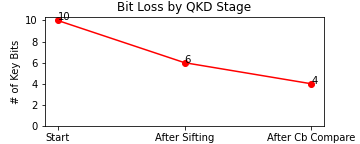

In [114]:
update()
dashboard

In [111]:
qc.draw()

░           ░               
q_0: ───────────░───────────░───────────────
                ░           ░               
q_1: ───────────░───────────░───────────────
                ░           ░               
q_2: ───────────░───────────░───────────────
                ░           ░               
q_3: ───────────░───────────░───────────────
     ┌───┐┌───┐ ░ ┌─┐       ░ ┌───┐┌─┐      
q_4: ┤ X ├┤ H ├─░─┤M├───────░─┤ H ├┤M├──────
     └───┘└───┘ ░ └╥┘       ░ └───┘└╥┘      
q_5: ───────────░──╫────────░───────╫───────
                ░  ║        ░       ║       
q_6: ───────────░──╫────────░───────╫───────
                ░  ║ ┌─┐    ░       ║ ┌─┐   
q_7: ───────────░──╫─┤M├────░───────╫─┤M├───
                ░  ║ └╥┘    ░       ║ └╥┘   
q_8: ───────────░──╫──╫─────░───────╫──╫────
     ┌───┐      ░  ║  ║ ┌─┐ ░ ┌───┐ ║  ║ ┌─┐
q_9: ┤ H ├──────░──╫──╫─┤M├─░─┤ H ├─╫──╫─┤M├
     └───┘      ░  ║  ║ └╥┘ ░ └───┘ ║  ║ └╥┘
c: 1/══════════════╩══╩══╩══════════╩══╩══╩═
                   0  0  0          0  0  0

In [46]:
update()

C:\Users\aadar\AppData\Local\Temp\ipykernel_14944\556153714.py:13: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if circ.data[i][1][0].index in dropbits and circ.data[i][0].name != 'barrier': #ADD CODE HERE


In [47]:
print(qc)

           ░                 ░                        
q_0: ──────░─────────────────░────────────────────────
           ░                 ░                        
q_1: ──────░─────────────────░────────────────────────
           ░ ┌─┐             ░      ┌─┐               
q_2: ──────░─┤M├─────────────░──────┤M├───────────────
     ┌───┐ ░ └╥┘┌─┐          ░      └╥┘┌─┐            
q_3: ┤ X ├─░──╫─┤M├──────────░───────╫─┤M├────────────
     ├───┤ ░  ║ └╥┘          ░ ┌───┐ ║ └╥┘┌─┐         
q_4: ┤ H ├─░──╫──╫───────────░─┤ H ├─╫──╫─┤M├─────────
     ├───┤ ░  ║  ║ ┌─┐       ░ └───┘ ║  ║ └╥┘┌─┐      
q_5: ┤ X ├─░──╫──╫─┤M├───────░───────╫──╫──╫─┤M├──────
     ├───┤ ░  ║  ║ └╥┘┌─┐    ░ ┌───┐ ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├─░──╫──╫──╫─┤M├────░─┤ H ├─╫──╫──╫──╫─┤M├───
     └───┘ ░  ║  ║  ║ └╥┘    ░ └───┘ ║  ║  ║  ║ └╥┘   
q_7: ──────░──╫──╫──╫──╫─────░───────╫──╫──╫──╫──╫────
           ░  ║  ║  ║  ║     ░       ║  ║  ║  ║  ║    
q_8: ──────░──╫──╫──╫──╫─────░───────╫──╫──╫──╫──╫────
     ┌───┐

In [48]:
#dag = circuit_to_dag(qc)
#dag.draw()

In [49]:
qb = copy.deepcopy(qc)

In [50]:
qc.draw()

░                 ░                        
q_0: ──────░─────────────────░────────────────────────
           ░                 ░                        
q_1: ──────░─────────────────░────────────────────────
           ░ ┌─┐             ░      ┌─┐               
q_2: ──────░─┤M├─────────────░──────┤M├───────────────
     ┌───┐ ░ └╥┘┌─┐          ░      └╥┘┌─┐            
q_3: ┤ X ├─░──╫─┤M├──────────░───────╫─┤M├────────────
     ├───┤ ░  ║ └╥┘          ░ ┌───┐ ║ └╥┘┌─┐         
q_4: ┤ H ├─░──╫──╫───────────░─┤ H ├─╫──╫─┤M├─────────
     ├───┤ ░  ║  ║ ┌─┐       ░ └───┘ ║  ║ └╥┘┌─┐      
q_5: ┤ X ├─░──╫──╫─┤M├───────░───────╫──╫──╫─┤M├──────
     ├───┤ ░  ║  ║ └╥┘┌─┐    ░ ┌───┐ ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├─░──╫──╫──╫─┤M├────░─┤ H ├─╫──╫──╫──╫─┤M├───
     └───┘ ░  ║  ║  ║ └╥┘    ░ └───┘ ║  ║  ║  ║ └╥┘   
q_7: ──────░──╫──╫──╫──╫─────░───────╫──╫──╫──╫──╫────
           ░  ║  ║  ║  ║     ░       ║  ║  ║  ║  ║    
q_8: ──────░──╫──╫──╫──╫─────░───────╫──╫──╫──╫──╫────
     ┌───┐ ░  ║  ║  ║  ║ ┌─┐ ░       ║  ║  ║  ║  ║ ┌─┐
q_9: ┤ X ├─░──╫──╫──╫──╫─┤M├─░───────╫──╫──╫──╫──╫─┤M├
     └───┘ ░  ║  ║  ║  ║ └╥┘ ░       ║  ║  ║  ║  ║ └╥┘
c: 1/═════════╩══╩══╩══╩══╩══════════╩══╩══╩══╩══╩══╩═
              0  0  0  0  0          0  0  0  0  0  0

In [51]:
#testcode for dropping wires from quantum circuit
#remove_arr = [1,2,3]
def dropper():
    drop = [7,3,5,9]
    i = 0
    while i < len(qb.data):
        """
        if len(qc.data[i][1]) > 1:
            j = 0
            while j < len(qc.data[i][1]):
                if qc.data[i][1][j].index in drop:
                    #print("inside")
                    j+=1
                    #del circ.data[]
        """
        if qb.data[i][1][0].index in drop:
            #print("here")
            del qb.data[i]
            i-=1
        i+=1
    #print(qb.data)
    return qb
dropper().draw()

C:\Users\aadar\AppData\Local\Temp\ipykernel_14944\285876513.py:16: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if qb.data[i][1][0].index in drop:


░        ░               
q_0: ──────░────────░───────────────
           ░        ░               
q_1: ──────░────────░───────────────
           ░ ┌─┐    ░      ┌─┐      
q_2: ──────░─┤M├────░──────┤M├──────
           ░ └╥┘    ░      └╥┘      
q_3: ──────░──╫─────░───────╫───────
     ┌───┐ ░  ║     ░ ┌───┐ ║ ┌─┐   
q_4: ┤ H ├─░──╫─────░─┤ H ├─╫─┤M├───
     └───┘ ░  ║     ░ └───┘ ║ └╥┘   
q_5: ──────░──╫─────░───────╫──╫────
     ┌───┐ ░  ║ ┌─┐ ░ ┌───┐ ║  ║ ┌─┐
q_6: ┤ H ├─░──╫─┤M├─░─┤ H ├─╫──╫─┤M├
     └───┘ ░  ║ └╥┘ ░ └───┘ ║  ║ └╥┘
q_7: ──────░──╫──╫──░───────╫──╫──╫─
           ░  ║  ║  ░       ║  ║  ║ 
q_8: ──────░──╫──╫──░───────╫──╫──╫─
           ░  ║  ║  ░       ║  ║  ║ 
q_9: ──────░──╫──╫──░───────╫──╫──╫─
           ░  ║  ║  ░       ║  ║  ║ 
c: 1/═════════╩══╩══════════╩══╩══╩═
              0  0          0  0  0

In [52]:
#dag = circuit_to_dag(qc)
#layers = list(dag.multigraph_layers())
#removelist = ["q_1","q_2","q_3"]

#for i in removelist:
#    for node in dag.nodes_on_wire(i,only_ops = True):
#        dag.remove_op_node(node)
    #if node.wire in removelist:
    #dag.remove_descendants_of(node,only_ops = True)
    #dag.remove_op_node(node)
#n_remove = 2

# the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
#for i in removelist:
#    layer = layers[i]
#    for node in layer:
#        if node.type == 'op':
#            dag.remove_op_node(node)
#new_qc = dag_to_circuit(dag)

#print(new_qc)

In [54]:
measurement

Row
    [0] WidgetBox(height=120)
        [0] TextInput(name='Authentication Tag', value='Thirty two very v...)
        [1] Button(clicks=1, name='Measure')
    [1] Terminal(id=1707911745248)

In [55]:
# pn.Row(pn.WidgetBox(qubit_select, height=75), qubit_select, height=100)

In [56]:
# static_text = pn.widgets.StaticText(value=qubit_select.options[0].draw())
# static_text

In [57]:
# qubit_select.options[0].draw()

In [58]:
if mac:
    mac.nonce.hex()

In [59]:
mac

In [60]:
# network table

network = pd.DataFrame(columns=["Alice", "Bob", "Public"])
network

,Alice,Bob,Public


In [61]:
n = 100

alice_key, alice_basis = generate_key2(n)

In [62]:
alice_key

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [63]:
import time
import datetime

int(time.time()) // 1000

1654793

In [64]:
# Allowed delay
delay_threshold = 10 * 60 # 10 minutes

# Alice time
t_alice = time.time()

# Alice seed
alice_init_seed = int(np.ceil(t_alice / delay_threshold))
alice_init_seed

2757990

In [65]:
# Bob time
t_bob = time.time()

# Bob seed
bob_init_seed = int((t_bob+delay_threshold) / delay_threshold)
bob_init_seed

2757990

In [66]:
def generate_seed(init_seed):
    return np.abs(hash(str(init_seed)) // (2**32 - 1))

In [67]:
np.random.seed(generate_seed(alice_init_seed))

def generate_pad(n):
    return randint(2, size=n)

alice_otp = generate_pad(100)
alice_otp

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [68]:
np.random.seed(generate_seed(bob_init_seed))

bob_otp = generate_pad(100)
bob_otp

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [69]:
alice_otp == bob_otp

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [70]:
s = "01100110011001100110011001100110"
j = int(s, 2)
print(j)
print(bin(j))


1717986918
0b1100110011001100110011001100110


In [71]:
key = b'Sixteen byte key'
cipher = AES.new(key, AES.MODE_EAX)
print(cipher)